# Small demo for PICO extraction and text summarization with LLMs

Models selected: BioELECTRA-PICO for PIO extraction. C extraction is implemented as a manual search for frequent comparators (e.g. placebo). Extractive summarization is implemented with TextRank algorithm.

In [2]:
import os
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1" # suppresses Huggingface warning of storing data rather than symlinking it
from transformers import AutoTokenizer, AutoModelForPreTraining, pipeline

import sys
sys.path.append('../../')
# load functions for import of clinicaltrials.gov data written previously
from app.data.loader import load_trials_json, extract_from_clinicaltrials
from app.nlp.utils import * # custom functions required for NER and summarization
from app.nlp.evaluate_model import elements_from_cell, substring_partial_overlap, evaluate_ner_model_partial_overlap
from rouge_score import rouge_scorer # library for ROUGE score calculation

In [3]:
# Load and process data from clinicaltrials.gov
PROJECT_ROOT = 'c:\\Users\\elena.jolkver\\Documents\\github\\biomed_extractor'

# Data directory at top level
DATA_DIR = os.path.join(PROJECT_ROOT, 'data')

df_json = load_trials_json(filepath = DATA_DIR, filename ='example_trials.json')
#print(df_json.head())
mydf = extract_from_clinicaltrials(df_json)
mydf.head()

Loaded 100 records from example_trials.json


,nctId,briefSummary,detailedDescription,inclusion_criteria,exclusion_criteria,intervention_name_clean,outcomes_name
0,NCT00105105,The purpose of this study is to evaluate the e...,"This will be a double blind, placebo controlle...",diagnosis of alzheimer's disease; women must h...,women with an intact uterus; a clinically sign...,Mifepristone,effects on cognition
1,NCT00160147,This is a 10-week study with bifeprunox and pl...,,diagnosis of dementia of the alzheimer's type,history of seizure disorder; clinically signif...,bifeprunox; Placebo,Brief Psychiatric Rating Scale (BPRS) Total Score
2,NCT00299988,The overall goal of this double-blind Phase II...,Abnormal processing of the beta-amyloid protei...,1. diagnosis of probable alzheimer's disease (...,1. non-alzheimer dementia.2. active renal dise...,Intravenous Immunoglobulin; Placebo,ADAS-Cog; CGIC
3,NCT00334568,Clinical features in patients with the familia...,,meets the national institute of neurological a...,has a history of or suffers from claustrophobi...,Rosiglitazone XR (extended release) oral table...,Change in global and regional cerebral glucose...
4,NCT00362024,MK0952 is a phosphodiesterase type IV (PDE4) i...,,"male or females; age \>/= 55 years, with mild-...",patients must not be living in nursing home or...,MK0952; Comparator: Placebo,


In [4]:
# Load BioM-ELECTRA-Base-PICO model
# TODO: clean up C:\Users\USER\.cache\huggingface\hub, deleting unneeded models
#tokenizer = AutoTokenizer.from_pretrained("kamalkraj/BioELECTRA-PICO")
#model = AutoModelForPreTraining.from_pretrained("kamalkraj/BioELECTRA-PICO")
ner_pipeline = pipeline("token-classification", 
                        model="kamalkraj/BioELECTRA-PICO",
                        aggregation_strategy="simple")

Device set to use cpu


In [5]:
ner_res = process_trials_for_PICO(mydf, ner_pipeline)
ner_res.head()

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


,nctId,briefSummary,detailedDescription,inclusion_criteria,exclusion_criteria,intervention_name_clean,outcomes_name,population_extracted,intervention_extracted,outcome_extracted,comparator_extracted,summary_extracted
0,NCT00105105,The purpose of this study is to evaluate the e...,"This will be a double blind, placebo controlle...",diagnosis of alzheimer's disease; women must h...,women with an intact uterus; a clinically sign...,Mifepristone,effects on cognition,able to provide written informed consent; ambu...,1073; acetylcholinesterase; aricept exelon; re...,"cognition and behavior, depression, safety, as...",placebo,The purpose of this study is to evaluate the e...
1,NCT00160147,This is a 10-week study with bifeprunox and pl...,,diagnosis of dementia of the alzheimer's type,history of seizure disorder; clinically signif...,bifeprunox; Placebo,Brief Psychiatric Rating Scale (BPRS) Total Score,dementia of the alzheimer ' s type,bifeprunox,,,This is a 10-week study with bifeprunox and pl...
2,NCT00299988,The overall goal of this double-blind Phase II...,Abnormal processing of the beta-amyloid protei...,1. diagnosis of probable alzheimer's disease (...,1. non-alzheimer dementia.2. active renal dise...,Intravenous Immunoglobulin; Placebo,ADAS-Cog; CGIC,. 4. an able caregiver willing to participate ...,intravenous immunoglobulin; ivig,"cognitive, behavioral and functional measures;...",placebo,The overall goal of this double-blind Phase II...
3,NCT00334568,Clinical features in patients with the familia...,,meets the national institute of neurological a...,has a history of or suffers from claustrophobi...,Rosiglitazone XR (extended release) oral table...,Change in global and regional cerebral glucose...,and have not been confirmed as post - menopau...,,,,Clinical features in patients with the familia...
4,NCT00362024,MK0952 is a phosphodiesterase type IV (PDE4) i...,,"male or females; age \>/= 55 years, with mild-...",patients must not be living in nursing home or...,MK0952; Comparator: Placebo,,"age \ > / = 55 years, with mild - to - moderat...",mk0952; phosphodiesterase,,,MK0952 is a phosphodiesterase type IV (PDE4) i...


In [6]:
# small overview on results\n",
import pandas as pd
# work on copy of results\n",
ner_res_copy = ner_res.copy()
# expand table, so that each extracted element is in its own row
# first, split strings into lists
ner_res_copy = ner_res_copy.assign(
   intervention_extracted=ner_res_copy.intervention_extracted.str.split("; "),
    comparator_extracted=ner_res_copy.comparator_extracted.str.split("; "),
    outcome_extracted=ner_res_copy.outcome_extracted.str.split(r",\s*|;\s*")
)
# then explode lists into rows\n",
for col in ['intervention_extracted', 'comparator_extracted', 'outcome_extracted']:
    ner_res_copy = ner_res_copy.explode(col)
ner_res_copy.head()

,nctId,briefSummary,detailedDescription,inclusion_criteria,exclusion_criteria,intervention_name_clean,outcomes_name,population_extracted,intervention_extracted,outcome_extracted,comparator_extracted,summary_extracted
0,NCT00105105,The purpose of this study is to evaluate the e...,"This will be a double blind, placebo controlle...",diagnosis of alzheimer's disease; women must h...,women with an intact uterus; a clinically sign...,Mifepristone,effects on cognition,able to provide written informed consent; ambu...,1073,cognition and behavior,placebo,The purpose of this study is to evaluate the e...
0,NCT00105105,The purpose of this study is to evaluate the e...,"This will be a double blind, placebo controlle...",diagnosis of alzheimer's disease; women must h...,women with an intact uterus; a clinically sign...,Mifepristone,effects on cognition,able to provide written informed consent; ambu...,1073,depression,placebo,The purpose of this study is to evaluate the e...
0,NCT00105105,The purpose of this study is to evaluate the e...,"This will be a double blind, placebo controlle...",diagnosis of alzheimer's disease; women must h...,women with an intact uterus; a clinically sign...,Mifepristone,effects on cognition,able to provide written informed consent; ambu...,1073,safety,placebo,The purpose of this study is to evaluate the e...
0,NCT00105105,The purpose of this study is to evaluate the e...,"This will be a double blind, placebo controlle...",diagnosis of alzheimer's disease; women must h...,women with an intact uterus; a clinically sign...,Mifepristone,effects on cognition,able to provide written informed consent; ambu...,1073,as well as physical exams,placebo,The purpose of this study is to evaluate the e...
0,NCT00105105,The purpose of this study is to evaluate the e...,"This will be a double blind, placebo controlle...",diagnosis of alzheimer's disease; women must h...,women with an intact uterus; a clinically sign...,Mifepristone,effects on cognition,able to provide written informed consent; ambu...,1073,clinical laboratory tests,placebo,The purpose of this study is to evaluate the e...


In [10]:
#ner_res_copy.groupby('intervention_extracted').agg(count=('intervention_extracted', 'size')).sort_values(by='count', ascending=False)

interventions_tested = ner_res_copy.drop_duplicates(subset=['nctId', 'intervention_extracted']) \
    .groupby('intervention_extracted') \
    .agg(count=('intervention_extracted', 'size')) \
    .sort_values(by='count', ascending=False)

# Filter out empty intervention labels
interventions_tested = interventions_tested[interventions_tested.index != '']
interventions_tested

#ner_res_copy.groupby(['intervention_extracted', 'comparator_extracted']) 
#    .agg(count=('intervention_extracted', 'size')) 
#    .sort_values(by='count', ascending=False) "

,count
intervention_extracted,
bapineuzumab,5
acetylcholinesterase inhibitors,3
azeliragon,3
aducanumab,3
123,3
...,...
wei li bai capsule,1
whole brain radiation,1
whole brain rt,1


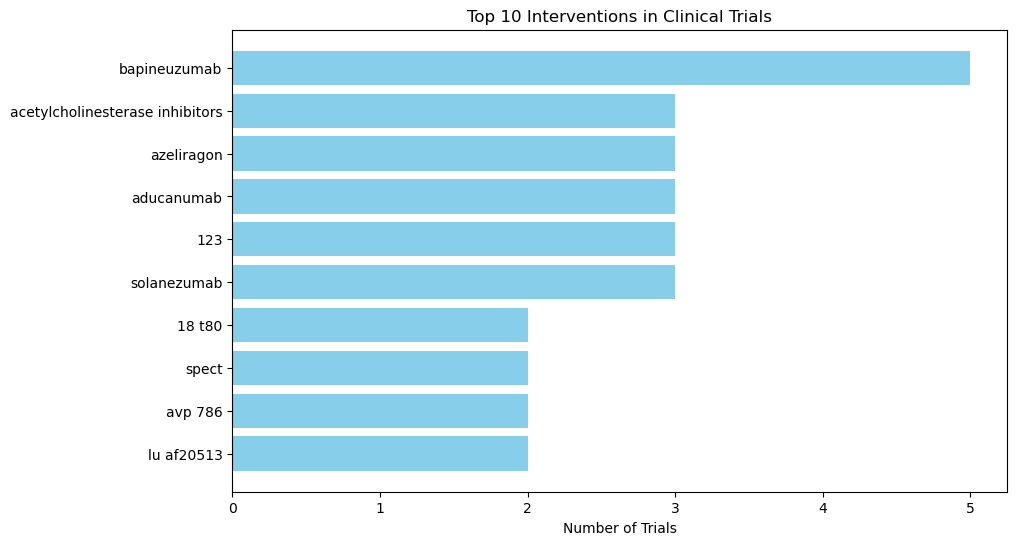

In [11]:
import matplotlib.pyplot as plt
# Plot the top 10 interventions
top_n = 10
top_interventions = interventions_tested.head(top_n)
plt.figure(figsize=(10, 6))
plt.barh(top_interventions.index, top_interventions['count'], color='skyblue')
plt.xlabel('Number of Trials')
plt.title(f'Top {top_n} Interventions in Clinical Trials')
plt.gca().invert_yaxis()  # Highest values on top\n",
plt.show()

The most often tested drug in the group of terminated alzheimer's trials in the experimental time frame is bapineuzumab. Bapineuzumab is a humanized form of murine monoclonal antibody 3D6, which targets the N-terminal region of Aβ. The rationale of this passive immunotherapy approach is that antibody binding will clear excess Aβ. All phrase 3 trials were terminated on August 6, 2012 because two large Phase 3 studies showed no clinical benefit.

## Evaluate model results on GOLD standard

In [6]:
# load gold standard trials
# Load and process data from clinicaltrials.gov
PROJECT_ROOT = 'c:\\Users\\elena.jolkver\\Documents\\github\\biomed_extractor'

# Data directory at top level
DATA_DIR = os.path.join(PROJECT_ROOT, 'data\\annotated')

df_json = load_trials_json(filepath = DATA_DIR, filename ='ctg-studies_for_gold.json')
#print(df_json.head())
mydf_manual_annotation = extract_from_clinicaltrials(df_json)
mydf_manual_annotation.head()

Loaded 20 records from ctg-studies_for_gold.json


,nctId,briefSummary,detailedDescription,inclusion_criteria,exclusion_criteria,intervention_name_clean,outcomes_name
0,NCT00667810,This is a study to evaluate the efficacy and s...,,"diagnosis of probable alzheimer disease (ad), ...",significant neurological disease other than ad...,bapineuzumab; placebo,The Change From Baseline in the Alzheimer's Di...
1,NCT00676143,This is a study to evaluate the efficacy and s...,,"diagnosis of probable ad, with mmse score of 1...",significant neurological disease other than ad...,bapineuzumab; placebo,Change From Baseline in Alzheimer's Disease As...
2,NCT01561430,The purpose of this Phase 1/Phase 2 study is t...,,meets criteria for mci due to ad or mild adall...,participant in another drug or device study; h...,LY2886721; Placebo,Change From Baseline to 12 Weeks in Cerebrospi...
3,NCT01900665,To test the idea that solanezumab will slow th...,,meets national institute of neurological and c...,does not have a reliable caregiver who is in f...,Solanezumab; Placebo,Change From Baseline in Alzheimer's Disease As...
4,NCT02565511,The purpose of this study was to test whether ...,The study (also known as the Generation Study ...,consented to receive disclosure of their risk ...,any disability that prevented the participant ...,CAD106 Immunotherapy; Placebo to CAD106; CNP52...,Time to Event (Diagnosis of Mild Cognitive Imp...


**How PICO elements and summary are extracted:**

Population: Extracted by running a NER pipeline on inclusion criteria. Only entities containing demographic/diagnosis keywords or sufficiently long phrases are retained and de-duplicated.

Intervention/Outcome: Extracted using NER on the main trial text (composed of briefSummary + detailedDescription) and cleaned by normalization, substring/fuzzy matching, and removal of generic or comparator terms.

Comparator: Extracted not by NER but by searching (using regular expressions or string matching) for a fixed list of comparator keywords (e.g., placebo, sham, usual care) within the intervention text.

Summary: Extracted by creating a brief extractive 2-sentence TextRank summary from the combined briefSummary and detailedDescription fields. This summary was compared against the original “briefSummary” as a reference, not the (unseen) full original description."


In [7]:
ner_res_model = process_trials_for_PICO(mydf_manual_annotation, ner_pipeline)
ner_res_model.sort_values(by=['nctId'], inplace=True)
# rename columns to match gold standard
ner_res_model.rename(columns={'population_extracted': 'population',
                             'intervention_extracted': 'intervention',
                             'comparator_extracted': 'comparator',
                                'outcome_extracted': 'outcome',
                                'summary_extracted': 'summary'}, inplace=True)
                                
ner_res_model.head()

,nctId,briefSummary,detailedDescription,inclusion_criteria,exclusion_criteria,intervention_name_clean,outcomes_name,population,intervention,outcome,comparator,summary
0,NCT00667810,This is a study to evaluate the efficacy and s...,,"diagnosis of probable alzheimer disease (ad), ...",significant neurological disease other than ad...,bapineuzumab; placebo,The Change From Baseline in the Alzheimer's Di...,diagnosis of probable alzheimer disease ( ad )...,bapineuzumab,efficacy; safety,,This is a study to evaluate the efficacy and s...
1,NCT00676143,This is a study to evaluate the efficacy and s...,,"diagnosis of probable ad, with mmse score of 1...",significant neurological disease other than ad...,bapineuzumab; placebo,Change From Baseline in Alzheimer's Disease As...,"diagnosis of probable ad, with mmse score of 1...",bapineuzumab,efficacy; safety,,This is a study to evaluate the efficacy and s...
2,NCT01561430,The purpose of this Phase 1/Phase 2 study is t...,,meets criteria for mci due to ad or mild adall...,participant in another drug or device study; h...,LY2886721; Placebo,Change From Baseline to 12 Weeks in Cerebrospi...,absence of dementia; clinical dementia rating ...,,,,The purpose of this Phase 1/Phase 2 study is t...
3,NCT01900665,To test the idea that solanezumab will slow th...,,meets national institute of neurological and c...,does not have a reliable caregiver who is in f...,Solanezumab; Placebo,Change From Baseline in Alzheimer's Disease As...,) result consistent with the presence of amylo...,solanezumab,cognitive decline,placebo,To test the idea that solanezumab will slow th...
4,NCT02565511,The purpose of this study was to test whether ...,The study (also known as the Generation Study ...,consented to receive disclosure of their risk ...,any disability that prevented the participant ...,CAD106 Immunotherapy; Placebo to CAD106; CNP52...,Time to Event (Diagnosis of Mild Cognitive Imp...,"homozygous apoe4 genotype.; male or female, ag...",cad106; cnp520,"and body weight loss; cognitive function, brai...",placebo,The purpose of this study was to test whether ...


In [8]:
# load GOLD-standard results
df_gold = load_trials_json(filepath = DATA_DIR, filename ='gold_standard.json')
for col in ["population", "intervention","comparator", "outcome"]:
    df_gold[col] = df_gold[col].apply(
        lambda x: '; '.join(str(e) for e in x) if isinstance(x, list) else x
    )
    # set to lowercase (to align with automatic extraction)
    df_gold[col] = df_gold[col].str.lower()
df_gold.sort_values(by=['doc_id'], inplace=True)
df_gold["intervention"] = df_gold["intervention"].apply(normalize_intervention)
df_gold

Loaded 20 records from gold_standard.json


,doc_id,summary,population,intervention,comparator,outcome
12,NCT00667810,[This is a study to evaluate the efficacy and ...,patients with mild to moderate alzheimer disease,bapineuzumab,placebo,the change from baseline in the alzheimer's di...
11,NCT00676143,[This is a study to evaluate the efficacy and ...,patients with mild to moderate alzheimer disease,bapineuzumab,placebo,change from baseline in alzheimer's disease as...
13,NCT01561430,[The purpose of this Phase 1/Phase 2 study is ...,participants with mild cognitive impairment (m...,ly2886721,placebo,change from baseline to 12 weeks in cerebrospi...
19,NCT01900665,[To test the idea that solanezumab will slow t...,participants with mild ad,solanezumab,placebo,change from baseline in alzheimer's disease as...
3,NCT02565511,[The purpose of this study was to test whether...,cognitively unimpaired apoe4 homozygotes (hms)...,cad106 immunotherapy cnp520 alum,placebo,time to event (diagnosis of mild cognitive imp...
7,NCT02769000,[Evaluate safety and toxicity/adverse events a...,patients with early alzheimer's dementia,radiation 10 gy radiation 20 gy,,ctcae toxicity grading
14,NCT02783573,[The main purpose of this study is to evaluate...,participants with mild alzheimer's disease (ad...,lanabecestat,placebo,change from baseline in alzheimer´s disease as...
9,NCT02791191,[The main purpose of this study is to evaluate...,participants with mild alzheimer's disease (ad...,ly3202626,placebo,change from baseline in f-av-1451 positron emi...
15,NCT02884492,[This study is being done to learn about tau t...,elderly subjects with different clinical and b...,18f thk 5351,,18f-thk-5351 standardized uptake value ratio
10,NCT02972658,[This study is an extension of study I8D-MC-AZ...,participants with early alzheimer's disease de...,lanabecestat,,change from baseline analysis on the 13-item a...


In [ ]:
# Evaluate model performance on the gold standard
pico_cols = ["population", "intervention", "comparator", "outcome"]
df_gold_with_partial, evaluation_table = evaluate_ner_model_partial_overlap(df_gold, 
                                                                            ner_res_model, 
                                                                            pico_cols, 
                                                                            summary_gold_col='summary', 
                                                                            summary_pred_col='summary', 
                                                                            add_rouge=True)
print(evaluation_table)

                 precision    recall        f1
element                                       
population        0.378636  0.722026  0.477297
intervention      0.794156  0.829167  0.759756
comparator        0.600000  0.566667  0.575000
outcome           0.362562  0.149262  0.155473
SUMMARY_ROUGE-1   0.798815  0.908080  0.833012
SUMMARY_ROUGE-2   0.768481  0.863371  0.798287
SUMMARY_ROUGE-L   0.779970  0.881646  0.812388


**Model Evaluation**

**-Population Extraction:**

The model extracts population information with relatively low precision but high recall, meaning it often identifies relevant population terms but also includes many incorrect or extractions. The F1 score suggests moderate overall performance for this element. Population entities were identified using a Named Entity Recognition (NER) pipeline applied primarily to the clinical trial’s inclusion criteria. Entities were filtered to keep those containing demographic or diagnostic keywords (like “patients,” “adults,” “participants”), or were sufficiently long. Further deduplication ensured removal of duplicates and irrelevant short/generic terms.

Recall is high (0.72): The NER pipeline detects most relevant population mentions in the inclusion text, so few true population groups are missed.

Precision is low (0.38): Many extracted entities are not true population descriptors—they might include overly broad terms, generic statements, or irrelevant/ambiguous phrases that “sneak through” the filters. This indicates an over-inclusive extraction.

F1 is moderate (0.48): The post-processing and rules applied after NER allow for capturing many relevant terms, but noise remains. Improving precision may require more refined patterns, stricter filtering, or model fine-tuning to better distinguish actual population descriptors from unrelated text.


**-Intervention Extraction:**

The intervention extraction shows strong performance across all metrics, achieving high precision and recall. This indicates that the model can reliably identify both the correct and most relevant interventions described in the studies. Intervention entities were extracted by applying NER to the combined “briefSummary” and “detailedDescription” fields. Interventions were subsequently normalized (lowercasing, removing punctuation, deduplicating via substring/fuzzy matching, and filtering out generic words and known comparators through rules).

Precision and recall are both high: The extraction and cleaning pipeline reliably identifies intervention terms, correctly excluding generic and comparator-related items. Most interventions described in the studies are captured, with few false positives.

F1 is high (0.76): The NER, normalization, and deduplication steps are very effective for intervention mentions, which often follow standard phrasing in clinical trial descriptions. This means your model/pipeline is well-tuned for identifying medical treatments, drugs, or procedures described as interventions.


**-Comparator Extraction:**

The comparator extraction is moderately successful, but there is room for improvement in both precision and recall. 
 
The reported scores for comparator do not reflect the NER model’s semantic understanding but rather the performance of a rule-based string search for typical comparator words. High or low scores in this element reflect the adequacy of the keyword list and matching strategy, not deep contextual comprehension.
 
**-Outcome Extraction:**

Outcome extraction shows the lowest scores, particularly in recall, meaning the model frequently misses important outcome-related information. Precision is also low, suggesting difficulty in correctly identifying outcome terms.

Outcome entities were extracted (via NER) primarily from the main trial text (“briefSummary” + “detailedDescription”) and further cleaned by removing irrelevant punctuation and deduplicating. No further deep semantic filtering was applied. Low recall indicates that many relevant outcomes described in the study are missed by the extraction pipeline. This often happens because outcome phrases are highly variable, domain-specific, and less standardized than interventions or population descriptions.

Precision is also low: Among the outcomes that are extracted, a substantial proportion do not match the gold standard (manual annotation)—underscoring challenges in both identification and correct labeling.

F1 is poor: Current rules and model performance for outcome extraction are not sufficient; a wide range of true outcome statements remain undetected. This typically happens because outcomes are often complex, multi-part, or intricately worded, and may need custom NER or more advanced semantic processing.

Recommendation: Improving outcome extraction may require richer domain-specific training for the NER model, targeted rules for outcome phrasing, or even leveraging structured data (if present) from trial registries.

**-Summary (ROUGE Scores):**

The model achieves high performance in extractive summarization, with strong ROUGE scores for unigram, bigram, and longest subsequence matches. The high recall values show the generated summaries cover most of the key content (which has been revealed in the brief Summary of the clinicaltrials.gov data), and the precision indicates the generation is relevant and concise. Keep in mind that the implemented summarization is extractive and uses TextRank on “briefSummary + description”. Its evaluated ROUGE scores (vs. the single “briefSummary” field) assess overlap with the trial’s own concise summary. A very high ROUGE might reflect redundancy—i.e., TextRank often picks similar or even identical sentences to those in briefSummary because it draws content directly from the same text pool. These metrics should not be interpreted as evidence of abstractive or generative summarization quality; rather, they indicate the ability of TextRank to extract content that matches what was originally selected as a summary by the trial authors.

**Overall Conclusion:**

The model performs best on intervention extraction and summary generation, with high precision and recall in those areas. Population and comparator extraction are moderate, while outcome extraction requires significant improvement. The summary quality is excellent according to ROUGE metrics, meaning that end-users will likely receive concise and representative study summaries. Further development should focus on improving outcome extraction accuracy and refining population/comparator detection."


In [11]:
df_gold_with_partial.head()

,doc_id,summary,population,intervention,comparator,outcome,population_partial_precision,population_partial_recall,population_partial_f1,intervention_partial_precision,...,outcome_partial_f1,summary_rouge1_precision,summary_rouge1_recall,summary_rouge1_f1,summary_rouge2_precision,summary_rouge2_recall,summary_rouge2_f1,summary_rougeL_precision,summary_rougeL_recall,summary_rougeL_f1
12,NCT00667810,[This is a study to evaluate the efficacy and ...,patients with mild to moderate alzheimer disease,bapineuzumab,placebo,the change from baseline in the alzheimer's di...,0.125000,0.428571,0.193548,1.0,...,0.100000,1.00,1.000000,1.000000,1.000000,1.000000,1.000000,1.00,1.000000,1.000000
11,NCT00676143,[This is a study to evaluate the efficacy and ...,patients with mild to moderate alzheimer disease,bapineuzumab,placebo,change from baseline in alzheimer's disease as...,0.066667,0.142857,0.090909,1.0,...,0.105263,1.00,1.000000,1.000000,1.000000,1.000000,1.000000,1.00,1.000000,1.000000
13,NCT01561430,[The purpose of this Phase 1/Phase 2 study is ...,participants with mild cognitive impairment (m...,ly2886721,placebo,change from baseline to 12 weeks in cerebrospi...,0.495327,0.950000,0.651148,0.0,...,0.000000,0.65,0.866667,0.742857,0.632911,0.847458,0.724638,0.65,0.866667,0.742857
19,NCT01900665,[To test the idea that solanezumab will slow t...,participants with mild ad,solanezumab,placebo,change from baseline in alzheimer's disease as...,0.100000,0.750000,0.176471,1.0,...,0.266667,1.00,1.000000,1.000000,1.000000,1.000000,1.000000,1.00,1.000000,1.000000
3,NCT02565511,[The purpose of this study was to test whether...,cognitively unimpaired apoe4 homozygotes (hms)...,cad106 immunotherapy cnp520 alum,placebo,time to event (diagnosis of mild cognitive imp...,0.250000,0.800000,0.380952,1.0,...,0.173913,1.00,1.000000,1.000000,1.000000,1.000000,1.000000,1.00,1.000000,1.000000


In [12]:
# combine results and gold standard
ner_res_model.rename(columns={'nctId': 'doc_id'}, inplace=True)
ner_res_model = ner_res_model[["doc_id","population", "intervention","comparator", "outcome"]].copy()
df_side_by_side = ner_res_model.merge(df_gold_with_partial, on='doc_id', how='outer', suffixes=('_extracted', '_gold'))
df_side_by_side

,doc_id,population_extracted,intervention_extracted,comparator_extracted,outcome_extracted,summary,population_gold,intervention_gold,comparator_gold,outcome_gold,...,outcome_partial_f1,summary_rouge1_precision,summary_rouge1_recall,summary_rouge1_f1,summary_rouge2_precision,summary_rouge2_recall,summary_rouge2_f1,summary_rougeL_precision,summary_rougeL_recall,summary_rougeL_f1
0,NCT00667810,diagnosis of probable alzheimer disease ( ad )...,bapineuzumab,,efficacy; safety,[This is a study to evaluate the efficacy and ...,patients with mild to moderate alzheimer disease,bapineuzumab,placebo,the change from baseline in the alzheimer's di...,...,0.100000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,NCT00676143,"diagnosis of probable ad, with mmse score of 1...",bapineuzumab,,efficacy; safety,[This is a study to evaluate the efficacy and ...,patients with mild to moderate alzheimer disease,bapineuzumab,placebo,change from baseline in alzheimer's disease as...,...,0.105263,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,NCT01561430,absence of dementia; clinical dementia rating ...,,,,[The purpose of this Phase 1/Phase 2 study is ...,participants with mild cognitive impairment (m...,ly2886721,placebo,change from baseline to 12 weeks in cerebrospi...,...,0.000000,0.650000,0.866667,0.742857,0.632911,0.847458,0.724638,0.650000,0.866667,0.742857
3,NCT01900665,) result consistent with the presence of amylo...,solanezumab,placebo,cognitive decline,[To test the idea that solanezumab will slow t...,participants with mild ad,solanezumab,placebo,change from baseline in alzheimer's disease as...,...,0.266667,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,NCT02565511,"homozygous apoe4 genotype.; male or female, ag...",cad106; cnp520,placebo,"and body weight loss; cognitive function, brai...",[The purpose of this study was to test whether...,cognitively unimpaired apoe4 homozygotes (hms)...,cad106 immunotherapy cnp520 alum,placebo,time to event (diagnosis of mild cognitive imp...,...,0.173913,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
5,NCT02769000,able to complete neurocognitive function asses...,beam irradiation; bnt; chemotherapy; external ...,,quality of life scores; alzheimer ' s and deme...,[Evaluate safety and toxicity/adverse events a...,patients with early alzheimer's dementia,radiation 10 gy radiation 20 gy,,ctcae toxicity grading,...,0.108108,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
6,NCT02783573,evidence of amyloid pathology.; for a diagnosi...,as lanabecestat,,,[The main purpose of this study is to evaluate...,participants with mild alzheimer's disease (ad...,lanabecestat,placebo,change from baseline in alzheimer´s disease as...,...,0.000000,0.564516,1.000000,0.721649,0.524590,0.941176,0.673684,0.564516,1.000000,0.721649
7,NCT02791191,mini - mental state examination score of 20 to...,ly3202626,,safety,[The main purpose of this study is to evaluate...,participants with mild alzheimer's disease (ad...,ly3202626,placebo,change from baseline in f-av-1451 positron emi...,...,0.000000,0.382353,0.829787,0.523490,0.326733,0.717391,0.448980,0.323529,0.702128,0.442953
8,NCT02884492,1. age 50 and older. 2. meet criteria for eith...,18f thk 5351; brain mri; neuropsychological; pet,,,[This study is being done to learn about tau t...,elderly subjects with different clinical and b...,18f thk 5351,,18f-thk-5351 standardized uptake value ratio,...,0.000000,0.564516,1.000000,0.721649,0.524590,0.941176,0.673684,0.564516,1.000000,0.721649
9,NCT02972658,participants previously enrolled in amaranth (...,azes; lanabecestat; ly3314814,placebo,adas - cog; alzheimer ' s disease assessment s...,[This study is an extension of study I8D-MC-AZ...,participants with early alzheimer's disease de...,lanabecestat,,change from baseline analysis on the 13-item a...,...,0.857143,0.500000,